# 8. Transfer Learning with TensorFlow Part 3: Scaling Up

## What we're going to cover

* Downloading and preparing 10% of all Food101 classes (7500+ training images)
* Training a transfer learning feature extraction model
* Fine-tuning our feature extraction model (Food Vision mini) to beat the original Food101 paper with only 10% of the data
* Evaluating Food Vision mini's predictions
 - Finding the most wrong predictions (on the test dataset)
* Making predictions with Food Vision mini on our own custom images

Our goal is to beat the original Food101 papaer with 10% of the training (leveraging the power of deep learning)

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [3]:
!nvidia-smi

Sun Jul 10 22:16:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8     6W /  N/A |    114MiB /  6144MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less Data

Our goal is to beat the original Food101 paper with 10% of the training data, so lets download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook

In [5]:
import zipfile
import os
DATA_DIR = "Data/Classification"
if os.path.exists(f'{DATA_DIR}/101_food_classes_10_percent') == False:
  !curl "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip" --output "Data/Classification/101_food_classes_10_percent.zip"
  zip_file = zipfile.ZipFile(f"{DATA_DIR}/101_food_classes_10_percent.zip")
  zip_file.extractall(f'{DATA_DIR}')
  zip_file.close()
  os.remove(f"{DATA_DIR}/101_food_classes_10_percent.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1550M    0  3308    0     0   3525      0   5d 08h --:--:--   5d 08h  3526
  0 1550M    0 3374k    0     0  2708k      0  0:09:45  0:00:01  0:09:44 2708k
  0 1550M    0 13.9M    0     0  6383k      0  0:04:08  0:00:02  0:04:06 6382k
  1 1550M    1 23.0M    0     0  7261k      0  0:03:38  0:00:03  0:03:35 7262k
  2 1550M    2 34.0M    0     0  8219k      0  0:03:13  0:00:04  0:03:09 8220k
  2 1550M    2 44.9M    0     0  8765k      0  0:03:01  0:00:05  0:02:56 10.4M
  3 1550M    3 55.9M    0     0  9168k      0  0:02:53  0:00:06  0:02:47 10.5M
  4 1550M    4 64.9M    0     0  9183k      0  0:02:52  0:00:07  0:02:45 10.1M
  4 1550M    4 74.3M    0     0  9233k      0  0:02:51  0:00:08  0:02:43 10.2M
  5 1550M    5 85.3M    0     0  9455k      0  0:02

In [6]:
# How many images/classes are there?
walk_through_dir(f"{DATA_DIR}/101_food_classes_10_percent")

There are 2 directories and 0 images in 'Data/Classification/101_food_classes_10_percent'.
There are 101 directories and 0 images in 'Data/Classification/101_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data/Classification/101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in 'Data/Classification/101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in 'Data/Classification/101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in 'Data/Classification/101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in 'Data/Classification/101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in 'Data/Classification/101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in 'Data/Classification/101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in 'D

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_dir = f"{DATA_DIR}/101_food_classes_10_percent/train"
test_dir = f"{DATA_DIR}/101_food_classes_10_percent/test"
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode = "categorical", image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode = "categorical", image_size = IMG_SIZE, shuffle = False) # don't shuffle test data for predictions

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model(we'll create our own output layer)
* Compile the model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# Create checkpoin callback
CHECKPOINT_DIR = "Checkpoint/Classification"
checkpoint_path = f"{CHECKPOINT_DIR}/Transfer_Learning_Scaling_Up"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_best_only = True, monitor = "val_accuracy")

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation 
data_augmentation = Sequential(
    [
     preprocessing.RandomFlip("horizontal"),
     preprocessing.RandomZoom(0.2),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2),
    #  preprocessing.Recaling(1./255) # rescale inputs of images to between 0 and 1; required for models like ResNet50
    ], name = "data_augmentation_layer"
)

## Headless EfficientNetB0 Model using Functional API

In [10]:
effnet_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
effnet_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape = IMG_SIZE +(3,), name = "input_layer")

# Add in the data augmentation layer
x = data_augmentation(inputs)

# Add in the efficientnet model
x = effnet_model(x, training = False)

# Now throw in that GlobalAveragePooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pool_layer")(x)

# Finally a dense layer to get classification predictions
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)

# Now make it into a model
model = tf.keras.Model(inputs, outputs, name = "model_scaling_up")

In [11]:
model.summary()

Model: "model_scaling_up"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool_layer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381


In [12]:
# Compile the model
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
TENSORBOARD_DIR = "TensorBoard/Classification"
# Fit the model
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.25*len(test_data)),
    callbacks = [create_tensorboard_callback(TENSORBOARD_DIR, "effnet_model_101_classes_10_pct"), checkpoint]
)

Saving TensorBoard log files to: TensorBoard/Classification/effnet_model_101_classes_10_pct/20220710-221957
Epoch 1/5
237/237 [==============================] - 140s 526ms/step - loss: 3.3719 - accuracy: 0.2763 - precision: 0.9453 - recall: 0.0251 - val_loss: 2.4339 - val_accuracy: 0.4475 - val_precision: 0.9407 - val_recall: 0.0528
Epoch 2/5
237/237 [==============================] - 94s 395ms/step - loss: 2.1953 - accuracy: 0.4964 - precision: 0.9423 - recall: 0.1509 - val_loss: 1.9860 - val_accuracy: 0.5154 - val_precision: 0.8925 - val_recall: 0.1632
Epoch 3/5
237/237 [==============================] - 83s 352ms/step - loss: 1.8184 - accuracy: 0.5712 - precision: 0.9208 - recall: 0.2532 - val_loss: 1.8671 - val_accuracy: 0.5192 - val_precision: 0.8587 - val_recall: 0.2265
Epoch 4/5
237/237 [==============================] - 84s 355ms/step - loss: 1.6124 - accuracy: 0.6054 - precision: 0.9178 - recall: 0.3241 - val_loss: 1.7764 - val_accuracy: 0.5330 - val_precision: 0.8392 - val_re

In [13]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 75s 95ms/step - loss: 1.5914 - accuracy: 0.5811 - precision: 0.8555 - recall: 0.3776


[1.5914429426193237,
 0.5811089277267456,
 0.8554508686065674,
 0.37758415937423706]

Whoa! We seem to have already achieved our objective. And that too in just 10 minutes. This illustrates the power of deep learning.

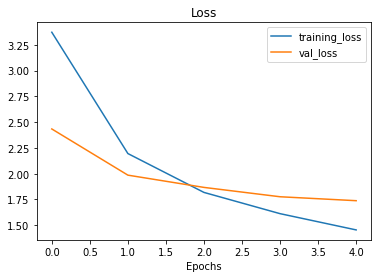

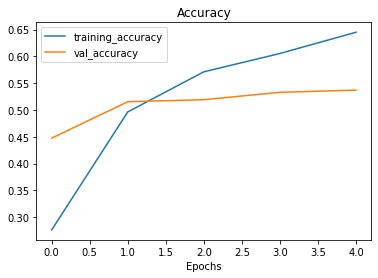

In [14]:
plot_loss_curves(history_all_classes_10_percent)

Ah but we seem to be overfitting. Where's our train data?

## Fine-Tuning

In [15]:
# Unfreeze all of the layers in the base model
effnet_model.trainable = True

# Refreeze every layer except the last 5
for layer in effnet_model.layers[:-5]:
  layer.trainable = False

In [16]:
len(effnet_model.trainable_variables)

6

In [17]:
# Recompile the model with a lower learning rate
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pool_layer True
output_layer True


In [18]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(effnet_model.layers):
  print(f'{layer_number}. {layer.name} => {layer.trainable}')

0. input_1 => False
1. rescaling => False
2. normalization => False
3. tf.math.truediv => False
4. stem_conv_pad => False
5. stem_conv => False
6. stem_bn => False
7. stem_activation => False
8. block1a_dwconv => False
9. block1a_bn => False
10. block1a_activation => False
11. block1a_se_squeeze => False
12. block1a_se_reshape => False
13. block1a_se_reduce => False
14. block1a_se_expand => False
15. block1a_se_excite => False
16. block1a_project_conv => False
17. block1a_project_bn => False
18. block2a_expand_conv => False
19. block2a_expand_bn => False
20. block2a_expand_activation => False
21. block2a_dwconv_pad => False
22. block2a_dwconv => False
23. block2a_bn => False
24. block2a_activation => False
25. block2a_se_squeeze => False
26. block2a_se_reshape => False
27. block2a_se_reduce => False
28. block2a_se_expand => False
29. block2a_se_excite => False
30. block2a_project_conv => False
31. block2a_project_bn => False
32. block2b_expand_conv => False
33. block2b_expand_bn => Fal

In [19]:
# Next we will train it for 5 epochs more over the initial 5 epochs
fine_tune_epochs = 10

checkpoint_dir = f"{CHECKPOINT_DIR}/effnetb0_full_10_percent_fine_tuned.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor = "val_accuracy", save_best_only = True, save_weights_only = True, save_freq = "epoch")

history_all_10_percent_fine_tuned = model.fit(
    train_data_all_10_percent,
    epochs = fine_tune_epochs,
    initial_epoch = history_all_classes_10_percent.epoch[-1] + 1,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    callbacks = [create_tensorboard_callback(TENSORBOARD_DIR,"effnetb0_full_10_percent_fine_tuned"), checkpoint]
)

Saving TensorBoard log files to: TensorBoard/Classification/effnetb0_full_10_percent_fine_tuned/20220710-222915
Epoch 6/10
237/237 [==============================] - 86s 306ms/step - loss: 1.2114 - accuracy: 0.6850 - precision_1: 0.8877 - recall_1: 0.5030 - val_loss: 1.7296 - val_accuracy: 0.5368 - val_precision_1: 0.7536 - val_recall_1: 0.4002
Epoch 7/10
237/237 [==============================] - 70s 294ms/step - loss: 1.1024 - accuracy: 0.7064 - precision_1: 0.8842 - recall_1: 0.5546 - val_loss: 1.7071 - val_accuracy: 0.5450 - val_precision_1: 0.7455 - val_recall_1: 0.4142
Epoch 8/10
237/237 [==============================] - 65s 274ms/step - loss: 1.0123 - accuracy: 0.7282 - precision_1: 0.8896 - recall_1: 0.5756 - val_loss: 1.6971 - val_accuracy: 0.5508 - val_precision_1: 0.7487 - val_recall_1: 0.4277
Epoch 9/10
237/237 [==============================] - 61s 258ms/step - loss: 0.9457 - accuracy: 0.7465 - precision_1: 0.9046 - recall_1: 0.6018 - val_loss: 1.6839 - val_accuracy: 0.54

In [20]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 76s 96ms/step - loss: 1.4937 - accuracy: 0.6034 - precision_1: 0.7696 - recall_1: 0.4985


[1.493729829788208,
 0.6034455299377441,
 0.7696117162704468,
 0.49849504232406616]

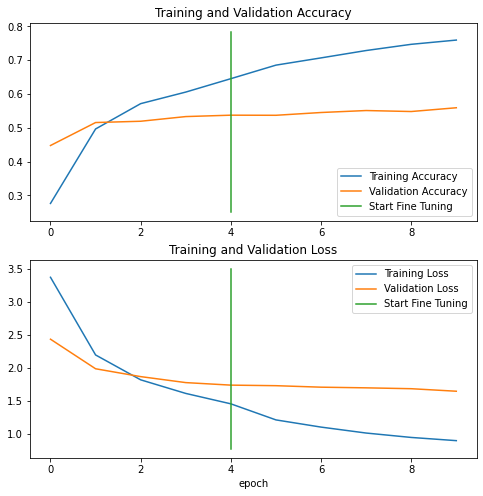

In [21]:
# Compare the histories of feature extraction model with the fine tuned model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_10_percent_fine_tuned,
                 initial_epochs = 5)

Yeah this looks like the overfitting simply continued. We need to do something to resolve this.

## Saving and Loading the trained model

In [22]:
# Save our fine-tuned model
SAVE_DIR = "Models/Classification_with_Tensorflow"
model.save(f"{SAVE_DIR}/101_food_classes_10_percent_fine_tuned")

INFO:tensorflow:Assets written to: Models/Classification_with_Tensorflow/101_food_classes_10_percent_fine_tuned\assets


INFO:tensorflow:Assets written to: Models/Classification_with_Tensorflow/101_food_classes_10_percent_fine_tuned\assets


In [23]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model(f"{SAVE_DIR}/101_food_classes_10_percent_fine_tuned")

In [24]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 82s 101ms/step - loss: 1.4937 - accuracy: 0.6034 - precision_1: 0.7696 - recall_1: 0.4985


[1.493729829788208,
 0.6034455299377441,
 0.7696117162704468,
 0.49849504232406616]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualise them and then later find out which predictions were the "most" wrong.

In [25]:
import tensorflow as tf

# Download pre-trained model (one that was prepared earlier, so that all predictions are similar)
!curl "https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip" --output "Models/Classification_with_Tensorflow/06_101_food_class_10_percent_saved_big_dog_model.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 44.5M    2 1326k    0     0  1191k      0  0:00:38  0:00:01  0:00:37 1191k
 24 44.5M   24 10.9M    0     0  5291k      0  0:00:08  0:00:02  0:00:06 5292k
 46 44.5M   46 20.6M    0     0  6798k      0  0:00:06  0:00:03  0:00:03 6799k
 70 44.5M   70 31.5M    0     0  7845k      0  0:00:05  0:00:04  0:00:01 7846k
 91 44.5M   91 40.8M    0     0  8188k      0  0:00:05  0:00:05 --:--:-- 8548k
100 44.5M  100 44.5M    0     0  8340k      0  0:00:05  0:00:05 --:--:--  9.9M


In [26]:
unzip_data("Models/Classification_with_Tensorflow/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [27]:
# Load in the saved model
down_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [28]:
# Evaluate the loaded model(the one we just downloaded on test data)
results_downloaded_model = down_model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 78s 97ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [29]:
# Make predictions with model
pred_probs = down_model.predict(test_data, verbose = 1) # set verbosity to see how long is left

790/790 [==============================] - 76s 94ms/step


In [30]:
len(test_data)

790

In [31]:
pred_probs.shape

(25250, 101)

In [32]:
pred_classes = tf.argmax(pred_probs, axis = 1)
pred_classes[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([52,  0,  0, 80, 79], dtype=int64)>

Now we've got a predictions array of all of our model's predictions, to evaluate them , we need to compare them to the original test data labels

In [33]:
# To get our test_labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [34]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [35]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels, y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [36]:
import numpy as np
np.isclose(sklearn_accuracy, results_downloaded_model[1])

True

## Lets get visual: Making a confusion matrix

In [37]:
from extras.helper_functions import make_confusion_matrix

In [38]:
class_names = train_data_all_10_percent.class_names

In [39]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# We need to make some changes to our make_confusion matrix function
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed(plot x-labels vertically) ###
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

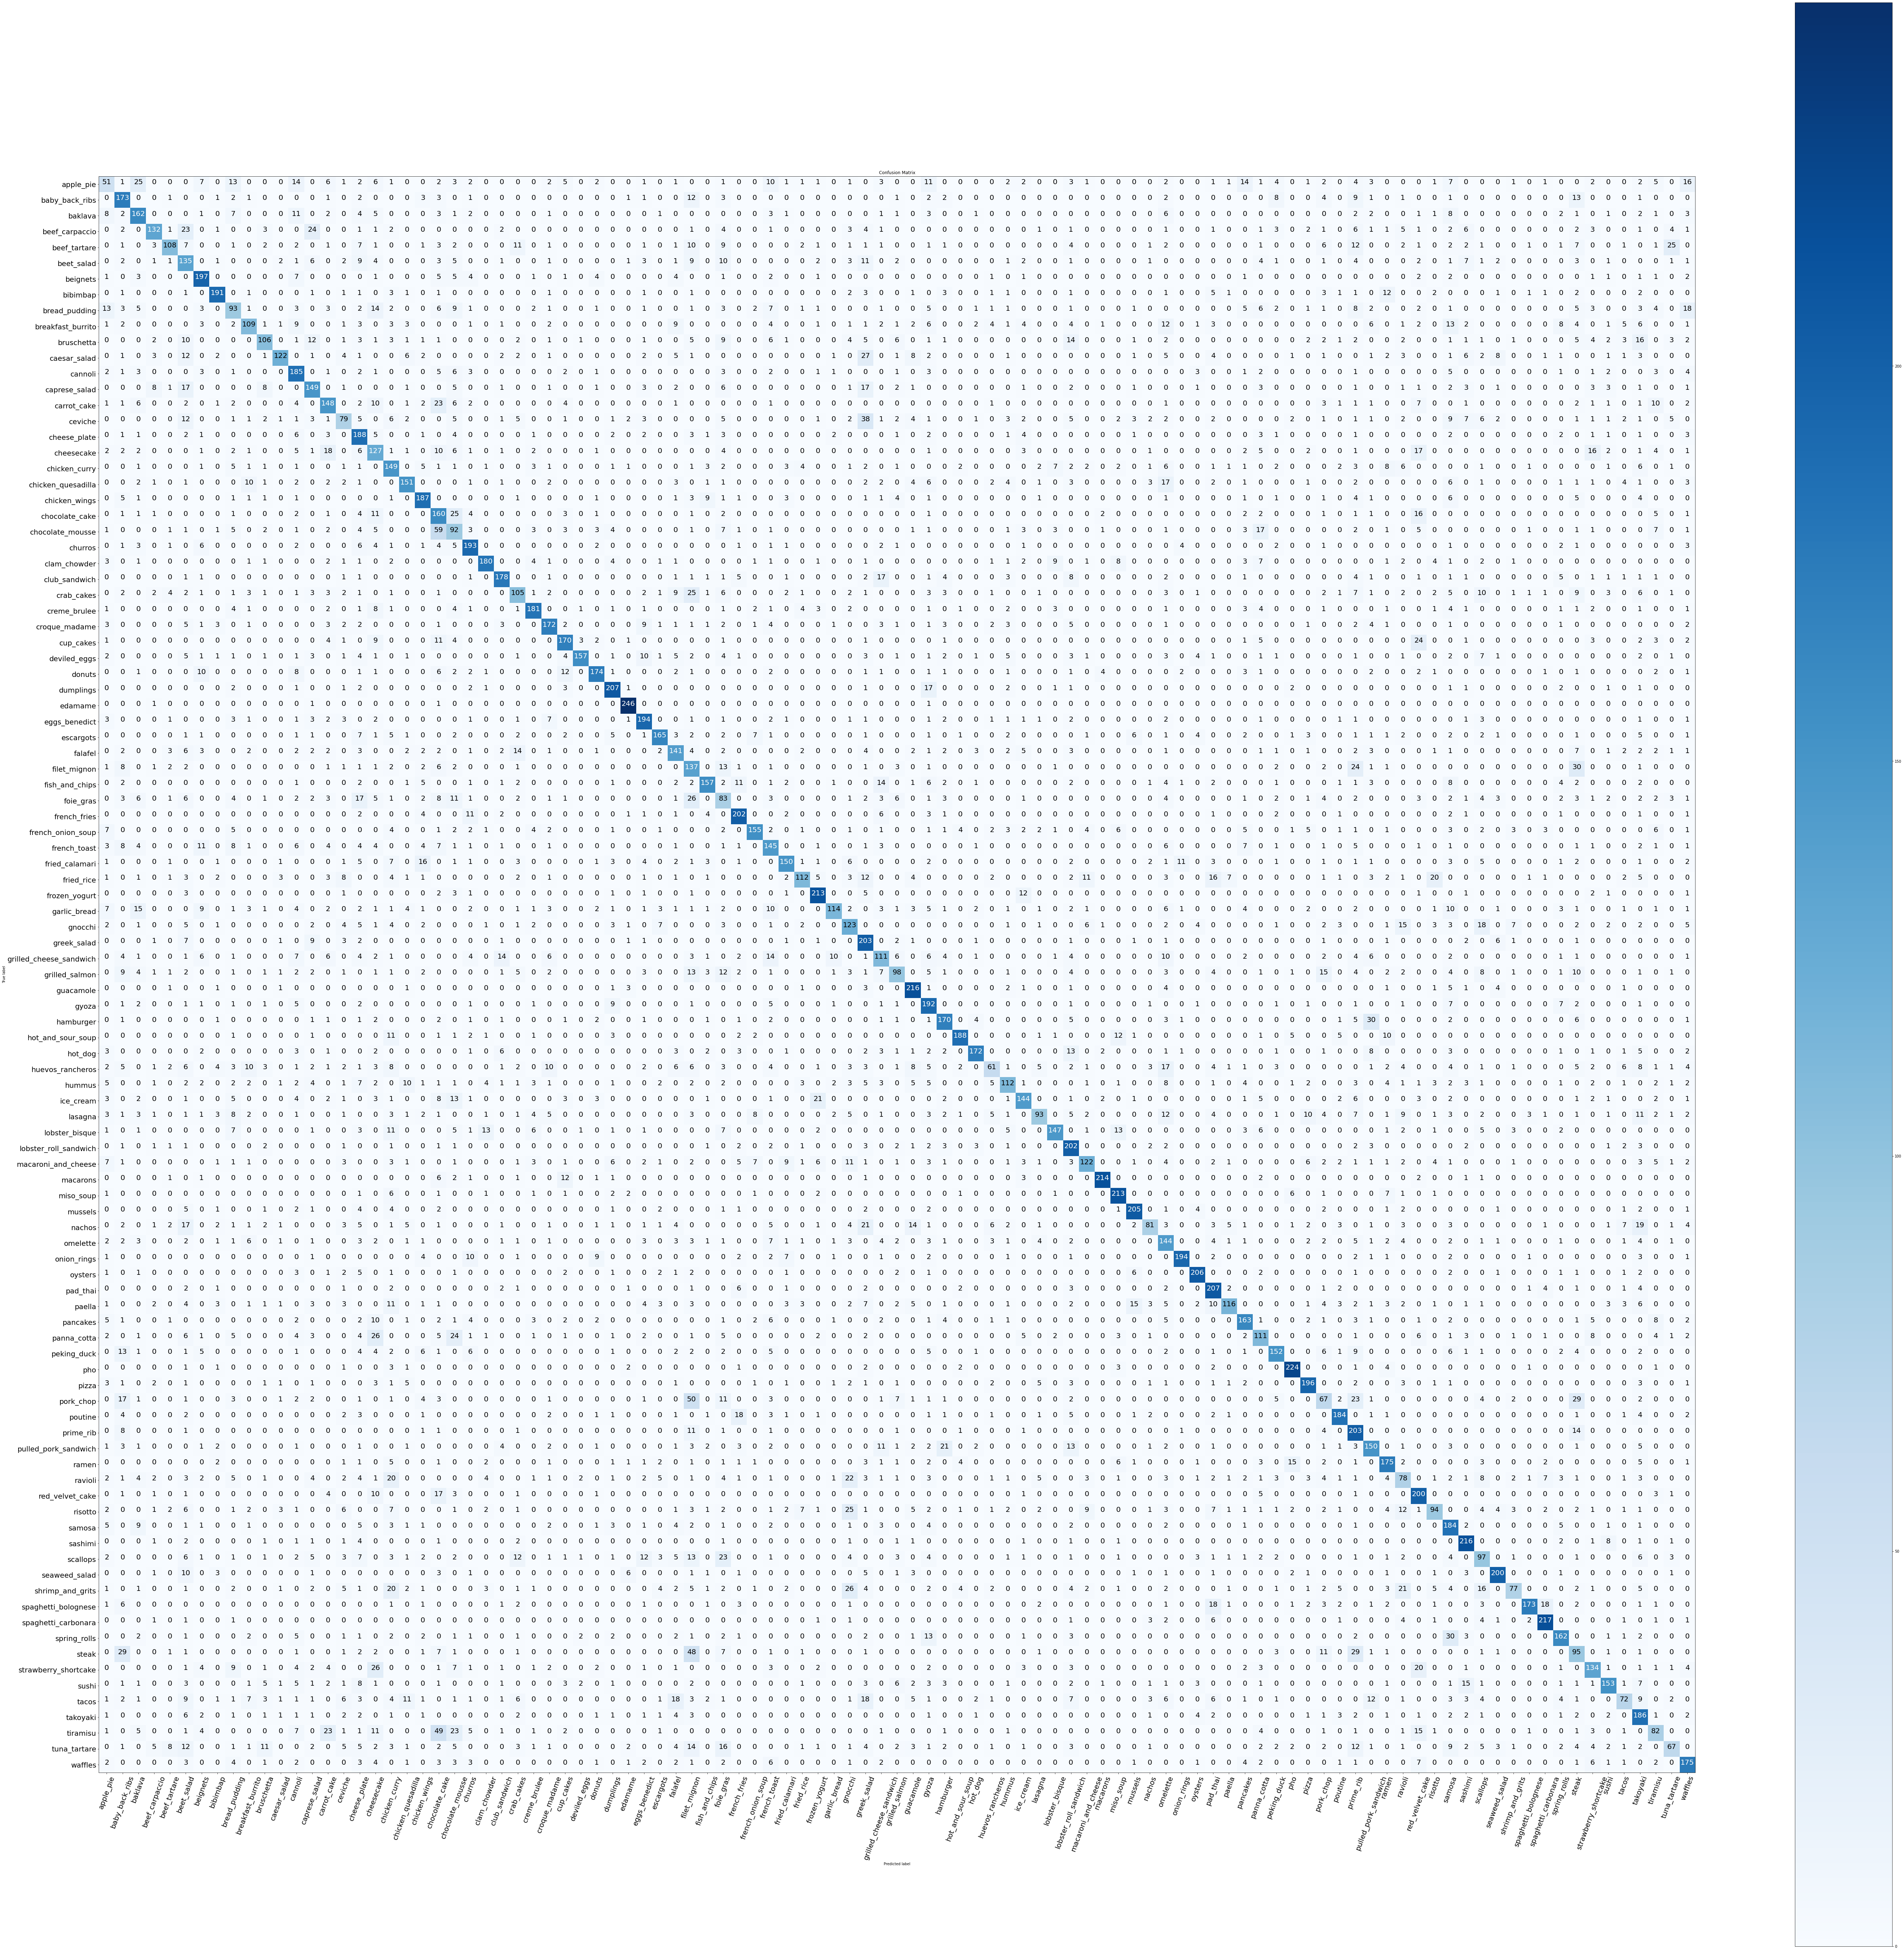

In [40]:
make_confusion_matrix(y_true = y_labels, y_pred = pred_classes, classes = class_names, figsize = (100,100), text_size = 20, savefig = True)

## Lets keep the evaluation train going, time for a classification report

Scikit-Learn has a helpful function for acquiring many different classification metrics per class (eg. precision, recall and F1) called classification report. Let's try it out!

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels, y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualisation to get a better understanding

In [42]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [43]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores...

In [44]:
# Create empty dictionary
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [45]:
# Turn f1-scores into datafram for visualisation
import pandas as pd

f1_scores = pd.DataFrame({'class_name': list(class_f1_scores.keys()), 'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending = False)
f1_scores

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


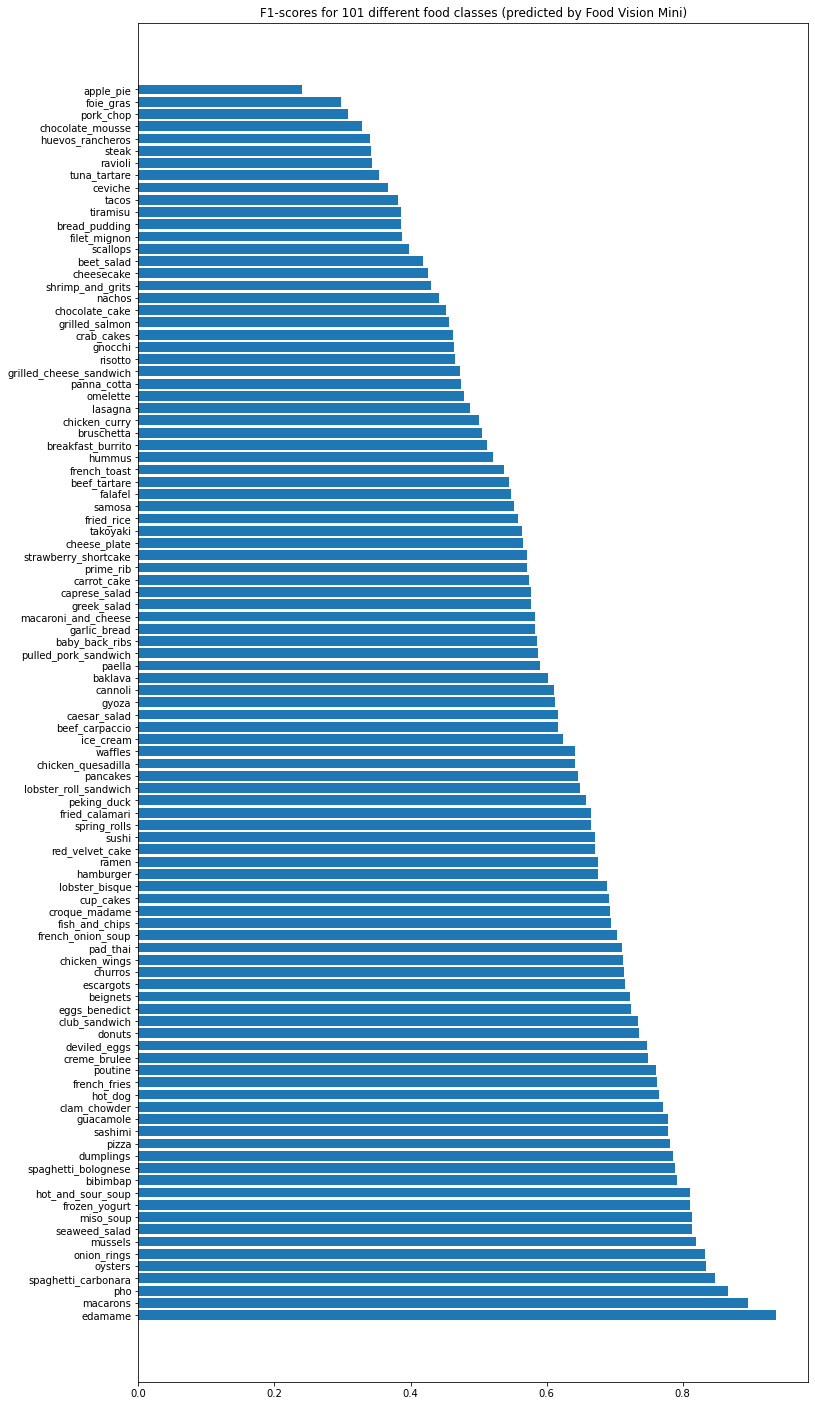

In [46]:
fig, ax = plt.subplots(figsize = (12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)));
ax.set_yticklabels(f1_scores['class_name']);
ax.set_title('F1-scores for 101 different food classes (predicted by Food Vision Mini)');

**Exercise:** Try visualising some of the most poorly predicted classes. Do you notice any trends among them?

## Visualising predictions on custom images

Now this is the real test. How does our model go on food images not even in our test dataset (images of our own).

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same sie as the images our model has trained on using tf.image.Resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [47]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape = 224, scale = True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels = 3)

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode the image file
  img = tf.io.decode_image(img, channels = 3)

  # Resize the image
  img = tf.image.resize(img, (img_shape, img_shape))

  if scale == True:
    img = img/255.
  
  return img

Now we've got a function to load and prepare target images, lets now write some code to visualise images, their target label and our model's predictions

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original imag(s) along with the model's predictions, prediction probability and truthe label

1/1 [==============================] - 0s 30ms/step


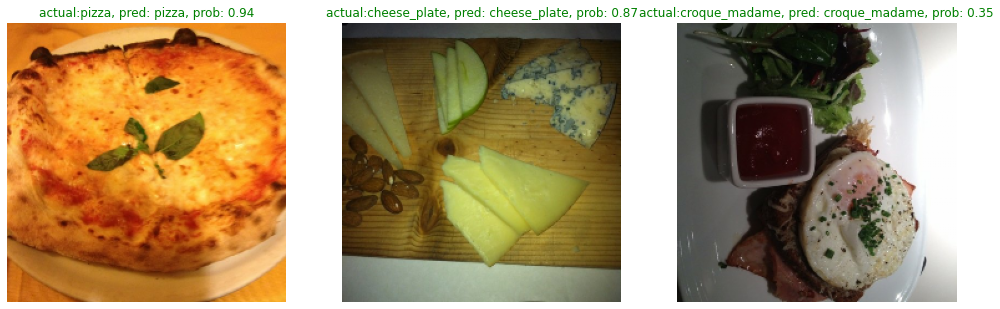

In [48]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from a random class
  
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale = False)
  img_expanded = tf.expand_dims(img, axis = 0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]
  
  # Plot the image(s)
  plt.subplot(1,3,i+1)
  plt.imshow(img/255)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  
  plt.title(f"actual:{class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, lets write some code to find out the following:

1. Get all of the image file paths in the test dataset using the list_files() method

2. Create a pandas DataFram of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities

3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).

4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).

5. Visualise the images with the highest prediction probabilities but have the wrong prediction.

In [76]:
# Get all the files
from tqdm import tqdm

files = test_data.list_files("Data/Classification/101_food_classes_10_percent/test/*/*.jpg", shuffle = False)
img_size = 224

# Create a pandas dataframe
dataframe_dict = {"filepath":[file.numpy() for file in files],
                  "ground_truth":[class_names[y_label] for y_label in y_labels],
                  "predicted_label":[class_names[pred_class] for pred_class in pred_classes],
                  "prediction_probability": tf.reduce_max(pred_probs, axis = 1)}

df = pd.DataFrame(dataframe_dict)

In [77]:
# df_sorted = df[df.ground_truth != df.predicted_label].sort_values("prediction_probability", ascending = False)
df_sorted = df[df.ground_truth != df.predicted_label].sort_values("prediction_probability", ascending = False)

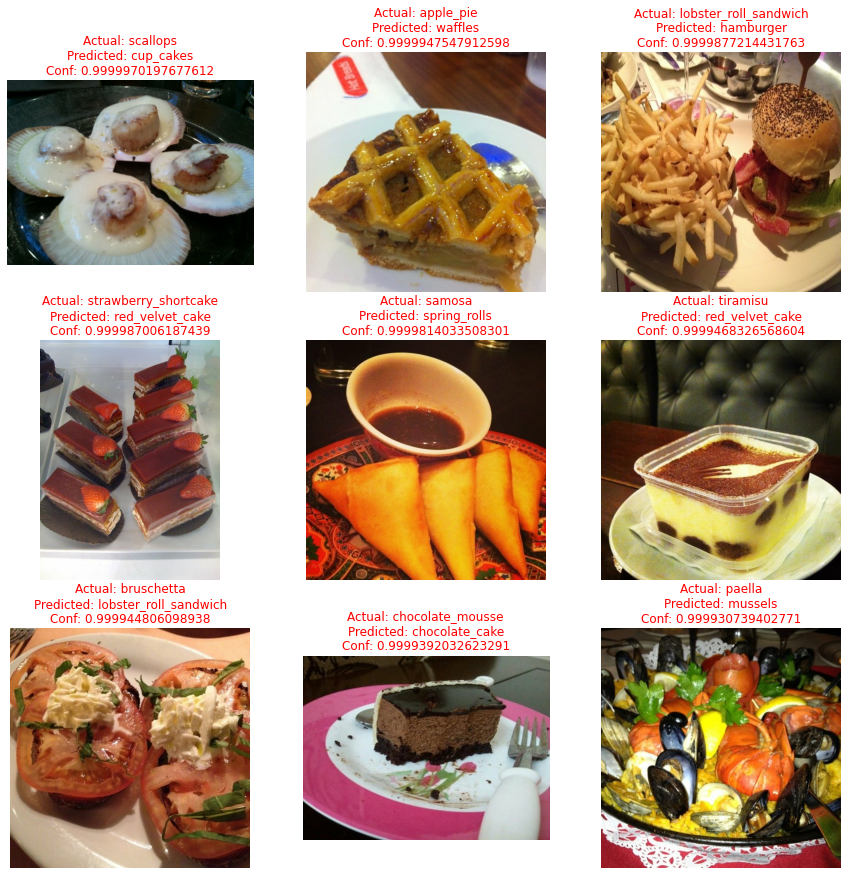

In [88]:
import math

def visualise_wrong_predictions(wrong_pred_df, num_to_display, num_cols = 3, figsize = (15,15)):
    """
    Where did we go wrong?
    """
    num_rows = math.ceil(num_to_display/num_cols)
    plt.figure(figsize = figsize)
    for num in range(num_to_display):
        row = wrong_pred_df.iloc[num]
        file = row["filepath"]
        ground_truth = row["ground_truth"]
        predicted_label = row["predicted_label"]
        prob = row["prediction_probability"]
        img = tf.io.read_file(file)
        img = tf.io.decode_image(img, channels = 3)
        plt.subplot(num_rows, num_cols, num + 1)
        plt.imshow(img)
        plt.title(f"Actual: {ground_truth}\nPredicted: {predicted_label}\nConf: {prob}", color = "r")
        plt.axis(False)

visualise_wrong_predictions(df_sorted, 9)